In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [2]:
# Set to True if want to generate new plot figues at runtime. The plots in README.md file will be updated.
gen_new_plots = False

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [3]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [4]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [5]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
yen_futures['Return'] = yen_futures.Settle.pct_change() * 100
yen_futures.dropna(inplace=True)

# In this case, you may have to replace inf, -inf values with np.nan"s
yen_futures['Return'].replace([np.inf, -np.inf], np.nan, inplace=True)

yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return
Date,,,,,,,,,
2014-02-18,9831.0,9865.0,9734.0,9775.0,42.0,9775.0,203495.0,196924.0,-0.427829
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502


### Lagged Returns 

In [6]:
# Create a lagged return using the shift function
yen_futures['Lagged_Return'] = yen_futures['Return'].shift().dropna()

yen_futures.dropna(inplace=True)

yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460,-0.427829
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465,-0.020460
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604,0.020465
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502,-0.204604
2014-02-25,9760.0,9808.0,9744.0,9789.0,32.0,9789.0,105498.0,201486.0,0.327970,0.020502


### Train Test Split

In [7]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2017']
test = yen_futures['2018':]

In [8]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Return"]
y_test = test["Return"]

In [9]:
# testing X_train
X_train.head()

,Lagged_Return
Date,
2014-02-19,-0.427829
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604
2014-02-25,0.020502


In [10]:
# testing X_test
X_test.head()

,Lagged_Return
Date,
2018-01-02,0.224871
2018-01-03,0.297285
2018-01-04,-0.240479
2018-01-05,-0.213028
2018-01-08,-0.353933


In [11]:
# testing y_train
y_train

Date
2014-02-19   -0.020460
2014-02-20    0.020465
2014-02-21   -0.204604
2014-02-24    0.020502
2014-02-25    0.327970
                ...   
2017-12-22    0.118370
2017-12-26    0.118230
2017-12-27   -0.151830
2017-12-28    0.180221
2017-12-29    0.224871
Name: Return, Length: 966, dtype: float64

In [12]:
# testing y_test
y_test.head()

Date
2018-01-02    0.297285
2018-01-03   -0.240479
2018-01-04   -0.213028
2018-01-05   -0.353933
2018-01-08    0.062017
Name: Return, dtype: float64

# Linear Regression Model

In [13]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [14]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [15]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
lr_results = y_test.to_frame()
lr_results['Predicted_Return'] = predictions

In [16]:
# test results
lr_results.head()

,Return,Predicted_Return
Date,,
2018-01-02,0.297285,-0.008621
2018-01-03,-0.240479,-0.008885
2018-01-04,-0.213028,-0.006923
2018-01-05,-0.353933,-0.007024
2018-01-08,0.062017,-0.006509


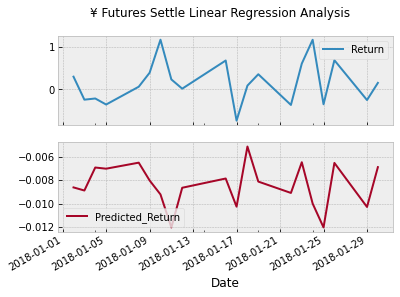

In [17]:
# Plot the first 20 predictions vs the true values
filtered_lr_results = lr_results[:20]
lr_results_fig = filtered_lr_results.plot(subplots = True, title='¥ Futures Settle Linear Regression Analysis')

if gen_new_plots: plt.savefig('img/linear_regression_results.png')

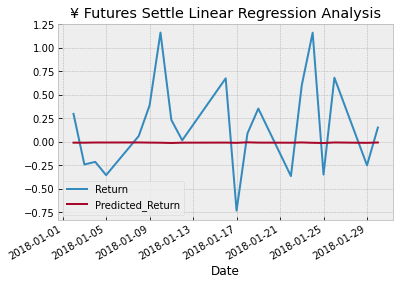

In [18]:
# Plot the first 20 predictions vs the true values
filtered_lr_results.plot(title='¥ Futures Settle Linear Regression Analysis')
if gen_new_plots: plt.savefig('img/linear_regression_results_overlay.png')

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [19]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    lr_results["Return"],
    lr_results["Predicted_Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.4154832784856737


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [20]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.5963660785073426


In [21]:
# Relevant metrics - score, r2, mse, rmse, std
from sklearn.metrics import r2_score

score = model.score(X_train, y_train, sample_weight=None)
r2 = r2_score(y_test, predictions)

# Print releveant metrics.
print(f"The score is {score}.")
print(f"The r2 is {r2}.")

The score is 1.3316694963294573e-05.
The r2 is -0.0011354260525680004.


# Conclusions

The results of the Linear Regression Analysis concluded a poor model fit performance, with the following results:

<code>Out-of-Sample Root Mean Squared Error (RMSE): 0.415</code>
<code>In-sample Root Mean Squared Error (RMSE): 0.60</code>

The R<sup>2</sup> shows very little correlation: <code>-0.0011</code>

The results were then plotted on 2 subplots:

![Linear Regression Subplots](img/linear_regression_results.png)

Analyzing the plots above, we can see some inverse-correlation. But, the amplitude of the data makes it very difficult to be properly fit. Normalizing the data can help eliminate the y-axis range discrepency.

But, with the current y-axis range, overlayed data does not provide any meaningful results:

![Linear Regression Subplots](img/linear_regression_results_overlay.png) 